In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Define the path to the ZIP file in Google Drive
zip_path = 'https://drive.google.com/file/d/1YvdQ0lsa5aqWB9OaLETU4oAfSDJckp5y/view?usp=sharing'  # Replace with the actual path to your ZIP file

In [7]:
import zipfile
import os
import gdown

# Step 1: Download the file from Google Drive
# Replace the part after 'id=' in the URL with the actual file ID.
file_id = '1_5G3Cz0WQtZeTxzsq5lrTUfEnNy78WeY'
zip_file_path = '/content/plant.zip'

# Downloading the file using gdown
gdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', zip_file_path, quiet=False)

# Step 2: Extract the zip file
extract_dir = '/content/plant'

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Verify extracted files
os.listdir(extract_dir)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1_5G3Cz0WQtZeTxzsq5lrTUfEnNy78WeY
From (redirected): https://drive.google.com/uc?export=download&id=1_5G3Cz0WQtZeTxzsq5lrTUfEnNy78WeY&confirm=t&uuid=e13107c7-fbe3-4a23-b74d-f012c8811332
To: /content/plant.zip

  0%|          | 0.00/1.49G [00:00<?, ?B/s]
  0%|          | 1.05M/1.49G [00:00<02:36, 9.48MB/s]
  1%|          | 8.91M/1.49G [00:00<00:34, 43.4MB/s]
  1%|          | 17.3M/1.49G [00:00<00:27, 52.8MB/s]
  2%|▏         | 29.4M/1.49G [00:00<00:20, 72.7MB/s]
  2%|▏         | 36.7M/1.49G [00:00<00:23, 61.4MB/s]
  3%|▎         | 43.5M/1.49G [00:00<00:25, 57.1MB/s]
  4%|▎         | 54.5M/1.49G [00:00<00:20, 70.1MB/s]
  4%|▍         | 62.4M/1.49G [00:00<00:20, 70.1MB/s]
  5%|▌         | 74.4M/1.49G [00:01<00:16, 83.6MB/s]
  6%|▌         | 84.4M/1.49G [00:01<00:18, 77.7MB/s]
  6%|▋         | 93.8M/1.49G [00:01<00:16, 82.0MB/s]
  7%|▋         | 104M/1.49G [00:01<00:15, 86.7MB/s] 
  8%|▊         | 113M/1.49G [00

['Plant_Disease_Dataset', '__MACOSX']

In [8]:
# Create training and validation sets
training_set = tf.keras.utils.image_dataset_from_directory(
    'train',
    labels="inferred",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

Found 70295 files belonging to 38 classes.


In [9]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    'valid',
    labels="inferred",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

Found 17572 files belonging to 38 classes.


In [10]:
# Load the EfficientNet model with pretrained weights
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model layers

In [11]:
# Add custom classification layers on top
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(1024, activation='relu')
dropout_layer = tf.keras.layers.Dropout(0.4)
output_layer = tf.keras.layers.Dense(38, activation='softmax')  # 38 classes

In [12]:
# Build the model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = dense_layer(x)
x = dropout_layer(x)
outputs = output_layer(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
# Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 38)                  │          38,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,400,265 (20.60 MB)

 Trainable params: 1,350,694 (5.15 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [15]:
# Train the model
training_history = model.fit(training_set, validation_data=validation_set, epochs=10)

Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 197s 78ms/step - accuracy: 0.7093 - loss: 1.2371 - val_accuracy: 0.9500 - val_loss: 0.1936
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 134s 54ms/step - accuracy: 0.9363 - loss: 0.2236 - val_accuracy: 0.9601 - val_loss: 0.1309
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 119s 54ms/step - accuracy: 0.9550 - loss: 0.1509 - val_accuracy: 0.9720 - val_loss: 0.0977
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 118s 54ms/step - accuracy: 0.9644 - loss: 0.1175 - val_accuracy: 0.9747 - val_loss: 0.0833
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 141s 53ms/step - accuracy: 0.9706 - loss: 0.0968 - val_accuracy: 0.9757 - val_loss: 0.0749
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 141s 53ms/step - accuracy: 0.9753 - loss: 0.0827 - val_accuracy: 0.9799 - val_loss: 0.0650
Epoch 7/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 163s 62ms/step - accuracy: 0.9783 - loss: 0.0733 - val_accuracy: 0.9785 - val_loss: 0.0653
Epoch 8/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 117s 53ms/step - accuracy: 

In [16]:
# Evaluate training and validation accuracy
train_loss, train_acc = model.evaluate(training_set)
print('Training accuracy:', train_acc)

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 99s 45ms/step - accuracy: 0.9924 - loss: 0.0253
Training accuracy: 0.9937833547592163


In [17]:
val_loss, val_acc = model.evaluate(validation_set)
print('Validation accuracy:', val_acc)

550/550 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - accuracy: 0.9842 - loss: 0.0495
Validation accuracy: 0.9841793775558472


In [20]:
!pip install tensorflow
!pip install matplotlib

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 454s 171ms/step - accuracy: 0.0272 - loss: nan - val_accuracy: 0.0271 - val_loss: nan
Epoch 2/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 317s 144ms/step - accuracy: 0.0268 - loss: nan - val_accuracy: 0.0271 - val_loss: nan
Epoch 3/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 316s 144ms/step - accuracy: 0.0275 - loss: nan - val_accuracy: 0.0271 - val_loss: nan
Epoch 4/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 322s 144ms/step - accuracy: 0.0270 - loss: nan - val_accuracy: 0.0271 - val_loss: nan
Epoch 5/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 314s 143ms/step - accuracy: 0.0277 - loss: nan - val_accuracy: 0.0271 - val_loss: nan


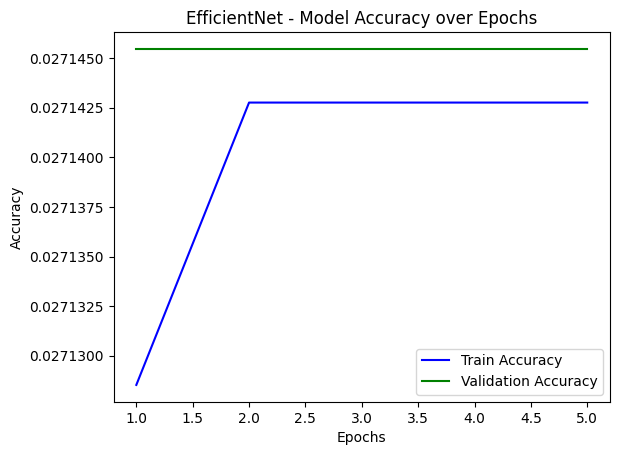

In [21]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define and compile your EfficientNet model
model = EfficientNetB0(weights=None, input_shape=(224, 224, 3), classes=10)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Use ImageDataGenerator for training and validation data loading
train_datagen = ImageDataGenerator(rescale=1./255)
train_set = train_datagen.flow_from_directory('/content/train', target_size=(224, 224), batch_size=32, class_mode='sparse')

val_datagen = ImageDataGenerator(rescale=1./255)
validation_set = val_datagen.flow_from_directory('/content/valid', target_size=(224, 224), batch_size=32, class_mode='sparse')

# Train the model and record the history of accuracy
history = model.fit(train_set, epochs=5, validation_data=validation_set)

# Plotting the accuracy graph
epochs = range(1, len(history.history['accuracy']) + 1)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='green')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('EfficientNet - Model Accuracy over Epochs')
plt.legend()

# Show the plot
plt.show()

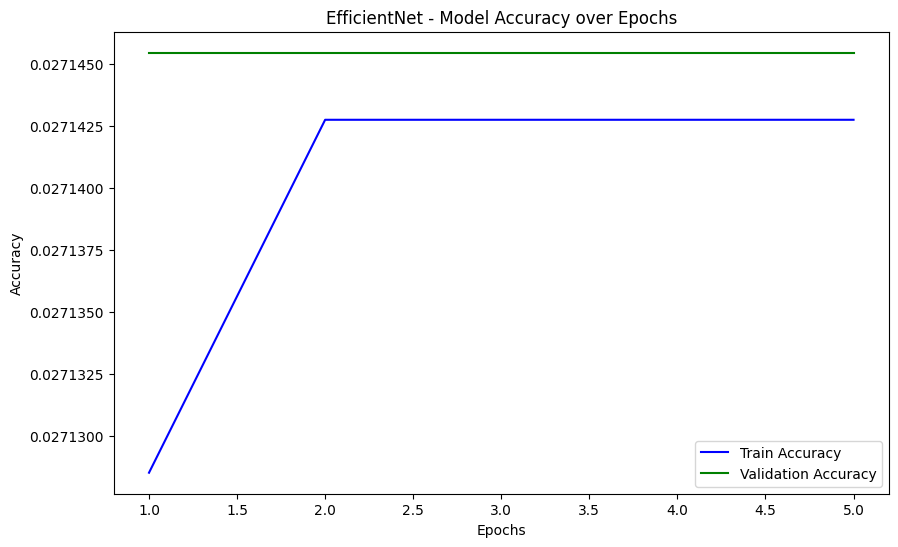

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming history is already obtained from model training
# Replace these lists with the actual history values
epochs = range(1, len(history.history['accuracy']) + 1)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting with Seaborn
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size for better clarity
sns.lineplot(x=epochs, y=train_accuracy, label='Train Accuracy', color='blue')
sns.lineplot(x=epochs, y=val_accuracy, label='Validation Accuracy', color='green')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('EfficientNet - Model Accuracy over Epochs')
plt.legend()

# Show the plot
plt.show()

In [19]:
# Save the trained model
model.save('trained_plant_disease_efficientnet_model.keras')

In [1]:
# Record training history
import json
with open('training_hist.json', 'w') as f:
    json.dump(training_history.history, f)

NameError: name 'training_history' is not defined

In [ ]:
# Plot accuracy history
epochs = range(1, 11)
plt.plot(epochs, training_history.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(epochs, training_history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

In [ ]:
# Prediction and evaluation
class_name = validation_set.class_names
test_set = tf.keras.utils.image_dataset_from_directory(
    'valid',
    labels="inferred",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

In [ ]:
y_pred = model.predict(test_set)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in test_set], axis=0)
Y_true = tf.argmax(true_categories, axis=1)

In [ ]:
# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(Y_true, predicted_categories)
print(classification_report(Y_true, predicted_categories, target_names=class_name))

plt.figure(figsize=(40, 40))
sns.heatmap(cm, annot=True, annot_kws={"size": 10})
plt.xlabel('Predicted Class', fontsize=20)
plt.ylabel('Actual Class', fontsize=20)
plt.title('Plant Disease Prediction Confusion Matrix', fontsize=25)
plt.show()